Imports

In [17]:
# Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math

# Tensorflow/keras imports
from keras import Sequential
from keras import layers
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from category_encoders import BinaryEncoder

import seaborn as sns

Data Import and Preprocessing

In [2]:
# Function for removing correlated features
def remove_correlated_features(df: pd.DataFrame, threshold: float) -> None:
    corr_matrix = df.corr(numeric_only = True)
    sns.heatmap(corr_matrix)
    plt.title("Features Correlation")
    plt.show()
    drop_cols = []
    # Iterate through the correlation matrix and compare correlations
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print("Correlated features: ", col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    df.drop(columns=drops, inplace=True)
    print('Removed Columns {}'.format(drops))


def display_confusion_matrix(y_pred, y_test) -> None:
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=np.unique(y_test))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test)).plot(cmap='Blues')
    plt.show()


Samples in df: 257673


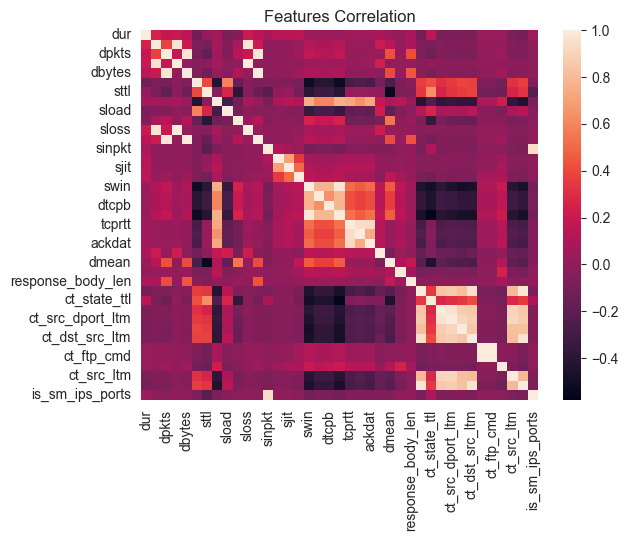

Correlated features:  sloss | sbytes | 1.0
Correlated features:  dloss | dbytes | 1.0
Correlated features:  dwin | swin | 0.98
Correlated features:  ct_ftp_cmd | is_ftp_login | 1.0
Removed Columns {'ct_ftp_cmd', 'dwin', 'dloss', 'sloss'}
Categorical features: ['proto', 'service', 'state']
Numerical features: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
Number of features after preprocessing: 51


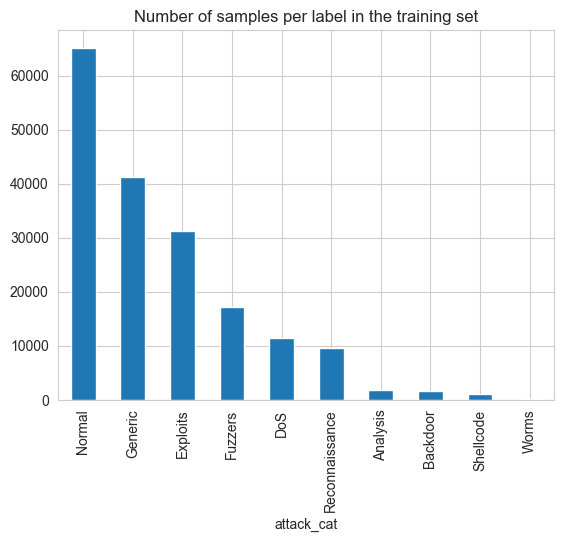

{0: 9.594202127659575, 1: 11.252089831565813, 2: 1.5699451649403777, 3: 0.5787428608098569, 4: 1.055233136371614, 5: 0.43795313827849947, 6: 0.2769357141760452, 7: 1.8648779983457402, 8: 17.444003868471953, 9: 152.85677966101696}


In [36]:
# Data files
train_set = pd.read_csv("UNSW_NB15_training-set.csv")
test_set = pd.read_csv("UNSW_NB15_testing-set.csv")

df = pd.concat([train_set, test_set])
df = df.drop(columns=['id', 'label'])

print(f"Samples in df: {len(df)}")

remove_correlated_features(df, 0.98)

X = df.drop(columns=['attack_cat'])
y = df['attack_cat']

# Encode categorical features using binary encoding
# Scale numerical features using standard scaler
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"Categorical features: {cat_features}")
print(f"Numerical features: {num_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), num_features),
        ("categorical", BinaryEncoder(handle_unknown="ignore"), cat_features)
    ], sparse_threshold=0
)
preprocessor.set_output(transform="pandas")
X = preprocessor.fit_transform(X)

print(f"Number of features after preprocessing: {X.shape[1]}")

# Create the test set with 30% of the total samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Use class weights to balance the classes for the training set
y_train.value_counts().plot.bar()
plt.title("Number of samples per label in the training set")
plt.show()

class_labels = np.unique(y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
print(class_weights)
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

Model structure and training

In [27]:
# Hyperparameters
epochs = 5
batch_size = 128
initial_lr = 0.01

# Function which will decrease the lr by 10% every n epochs
def lr_step_decay(epoch, lr):
    epochs_per_drop = 5
    return initial_lr * math.pow(0.9, math.floor(epoch/epochs_per_drop))

# Model
model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(384, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(384, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(np.unique(y_train))),
    layers.Activation("softmax")
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 256)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 384)            │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,202 (1.53 MB)

 Trainable params: 400,202 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile model
model.compile(
    optimizer = SGD(learning_rate=initial_lr, momentum=0.9),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

# Train model with proper callback
model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, class_weight=class_weights, verbose=1, callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

# Evaluate on test data
print("\nTest data loss/accuracy:")
print(model.evaluate(X_test, y_test))

# Display confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(model.predict(X_test), axis=1))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap='Blues', ax=plt.subplots(figsize=(12, 12))[1])
plt.show()


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/5
 111/1128 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.4715 - loss: 1.6088

KeyboardInterrupt: 

0.7975343458125275


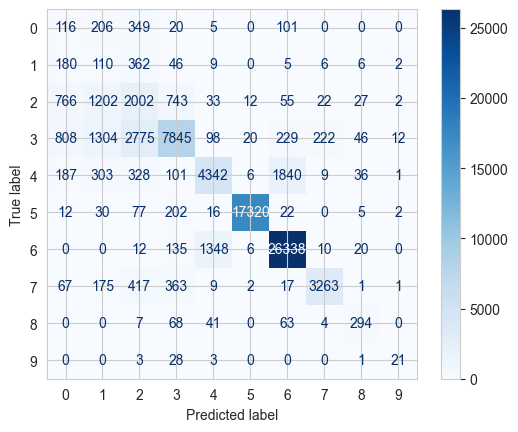

In [45]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight=class_weights).fit(X_train, y_train)
print(clf.score(X_test, y_test))
display_confusion_matrix(clf.predict(X_test), y_test)

In [30]:
from xgboost import XGBClassifier

clf = XGBClassifier().fit(X_train, y_train)
print(clf.score(X_test, y_test))
display_confusion_matrix(clf.predict(X_test), y_test)

0.9471553129285142